In [1]:
import torch
from torch import nn
from IPython import display
## lead helper functions from d2l
import sys
sys.path.insert(0, 'C:\\Users\\Shiwen\\dl_practice_pytorch\\function')
import d2l_torch as d2l

In [2]:
print(torch.cuda.device_count())
print(torch.cuda.is_available())

1
True


In [3]:
def try_gpu(i = 0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')
try_gpu(0)

device(type='cuda', index=0)

In [4]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

**Expore the Fashion Mnist Data**

In [5]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles is not None:
            ax.set_title(titles[i].item())
    return axes

In [6]:
X, y = next(iter(train_iter))
print(X.shape)
print(y.shape)
# print(y[3])
# show_images(X.reshape(16, 28, 28), 4, 4, titles = y);

torch.Size([256, 1, 28, 28])
torch.Size([256])


**Initial Torch Model**

In [7]:
# layer 1: flatten the 28 x 28 picture into 1 x 784
# layer 2: fully connected layer with 10 output dimension
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))
net = net.to(device = try_gpu())

# initial parameters in the fully connected layer
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

**Softmax Transformation + Cross Entroy Loss**

In [8]:
loss = nn.CrossEntropyLoss()

**Define Optimizer: Stochastic Gradient descent**

In [9]:
lr = 0.1
trainer = torch.optim.SGD(net.parameters(), lr)

**Define Accuracy and Accumulator**

In [10]:
# cumulatively add numbers into a list
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n
        
    # a list is the original value, b list is input value
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)] 
    
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    # to make metric[0] / metric[1] available
    def __getitem__(self, index):
        return self.data[index]

# define accuracy # of correct / total
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis = 1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

# # evaluate accuracy from a model
# def evaluate_accuracy_gpu(net, data_iter, device):
#     if isinstance(net, nn.Module):
#         net.eval()  # set the model to evaluation mode
#     metric = Accumulator(2)
#     for X, y in data_iter:
#         X, y = X.to(device), y.to(device)
#         metric.add(accuracy(net(X), y), y.numel())
#     return metric[0] / metric[1];

def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

**Define Training function for one Epoch**

In [11]:
def train_one_epoch_gpu(net, train_iter, loss, trainer, device):
    if isinstance(net, nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(trainer, torch.optim.Optimizer):
            trainer.zero_grad() # reset gradient
            l.backward() # back pop
            trainer.step() # update parameter
            metric.add(float(l) * len(y),
                      accuracy(y_hat, y),
                      y.size().numel())
    return metric[0] / metric[2], metric[1] / metric[2]

**Define Animator**

In [12]:
class Animator:  #@save
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

**Define Training function**

In [13]:
def train_net_gpu(net, train_iter, test_iter, loss, num_epochs, trainer, device):
    print('training on', device)
#     animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
#                         legend=['train loss', 'train acc', 'test acc'])
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                    legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_one_epoch_gpu(net, train_iter, loss, trainer, device)
        test_acc = evaluate_accuracy_gpu(net, test_iter, device)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

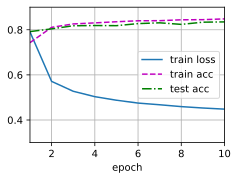

In [14]:
num_epochs = 10
train_net_gpu(net, train_iter, test_iter, loss, num_epochs, trainer, try_gpu())

In [15]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.0838,  0.0829, -0.0777,  ...,  0.0154, -0.0107,  0.0813],
        [ 0.0373,  0.0569,  0.0612,  ...,  0.0412,  0.0685,  0.0288],
        [-0.0514,  0.0422, -0.0655,  ...,  0.1106,  0.0238,  0.0252],
        ...,
        [-0.0268,  0.0280, -0.0785,  ..., -0.0925, -0.0012, -0.0208],
        [-0.0188,  0.0080,  0.0692,  ..., -0.0536, -0.0376, -0.0479],
        [ 0.0301, -0.0801, -0.0061,  ...,  0.0731, -0.0473, -0.0438]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.2692, -0.3495, -0.1086,  0.1810, -0.9082,  1.9015,  0.4154, -0.1099,
        -0.4108, -0.9898], device='cuda:0', requires_grad=True)


**Prediction**

In [40]:
def get_label(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def predict_gpu(net, test_iter, n, device):
    for X, y in test_iter:
        X, y = X.to(device), y.to(device)
        break
    actuals = get_label(y)
    preds = get_label(net(X).argmax(axis = 1))
    titles = ['A: ' + actual + '\n' + 'E: ' + pred for actual, pred in zip(actuals, preds)]
    d2l.show_images(X[0:n].to('cpu').reshape((n, 28, 28)), 1, n, titles=titles[0:n])

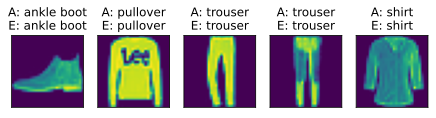

In [41]:
predict_gpu(net, test_iter, 5, try_gpu())